In [1]:
cd examples/

/home/vmu/nu_stats/examples


In [2]:
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import sys
sys.path.append("../")
from nu_stats.simulation import Simulation


In [4]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [5]:
Nsims = 1000
sims=[Simulation(L, gamma, z, F_diff_norm = F_diff_norm,
    Emin=Emin, Emax=Emax, Enorm=Enorm) for i in range(Nsims)]

In [6]:
for i in range(Nsims):
    sims[i].run(seed=i,verbose=False)
    if i>0:
        assert sims[i].truth == sims[i-1].truth
fit_inputs = [sim.get_data() for sim in sims]

In [7]:
Nevents = [fit_inputs[i]['N'] for i in range(Nsims)]
simtruef = sims[0].truth['f']

0.492

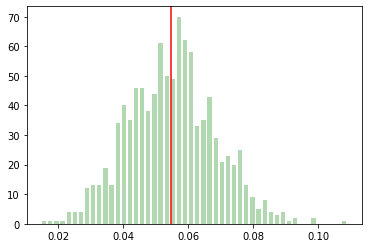

In [65]:
truenss = [sum(sim.labels==0) for sim in sims]
ratios = np.array([truenss[i]/Nevents[i] for i in range(Nsims)])
plt.hist(ratios, bins =50,
    color='g', alpha = .3, histtype='barstacked', rwidth = 0.7);
plt.axvline(simtruef, c='r');

(ratios<simtruef).mean()



# FITS

In [9]:
from nu_stats.fqutils import FqStructure
from nu_stats.bhmutils import BhStructure
from time import time
from arviz import hdi
credL = .68

In [22]:
startt = time()

nhs = [None]*Nsims
ghs = [None]*Nsims
nhratios = [None]*Nsims
ci_nhrs = [None]*Nsims
ci_ghs = [None]*Nsims
hdi_f = [None]*Nsims
hdi_g = [None]*Nsims

invalids = []
erroridx = []
for i in range(Nsims):
    f_i = fit_inputs[i]
    print('\n'*5,i)

    fq = FqStructure(fit_input=f_i)
    fq.construct_diffuse_bg_energy_likelihood(
        f_i['z_bg'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/False1.0_25lik.npy', verbose= False
    )
    fq.construct_source_energy_likelihood(
        f_i['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy', verbose= False
    )
    _, nh, gh = fq.minimize_neg_lbl()
    nhs[i] = nh
    ghs[i] = gh
    nhratios[i] = nh/Nevents[i]
    try:
        if fq.minuit.valid:
            # run Minos
            fq.minuit.minos()
            if not fq.minuit.merrors['n_s'].is_valid:
                print(f'WARNING: minos for n_s, sim {i} invalid')
                invalids.append(i)
            if not fq.minuit.merrors['gamma'].is_valid:
                print(f'WARNING: minos for gamma, sim {i} invalid')
                invalids.append(i)
            ci_nhrs[i] = ((nh+fq.minuit.merrors['n_s'].lower)/Nevents[i],
                (nh+fq.minuit.merrors['n_s'].upper)/Nevents[i])
            ci_ghs[i] = (gh+fq.minuit.merrors['gamma'].lower,
                gh+fq.minuit.merrors['gamma'].upper)
        else: # run HESSE instead
            print(f'WARNING: minuit for sim {i} invalid')
            invalids.append(i)
            fq.minuit.hesse()
            ci_nhrs[i] = ((nh-fq.minuit.errors['n_s'])/Nevents[i],
                (nh+fq.minuit.merrors['n_s'])/Nevents[i])
            ci_ghs[i] = (gh-fq.minuit.errors['gamma'],
                gh+fq.minuit.errors['gamma'])

        # ================================================================================
        bhm = BhStructure(fit_input=f_i)
        bhm.load_model("stan/toy_bhm.stan")
        bhm.run(seed=i*100)
        hdi_f[i] = hdi(bhm.fit.stan_variable('f'), hdi_prob=credL)
        hdi_g[i] = hdi(bhm.fit.stan_variable('gamma'), hdi_prob=credL)

    except:
        invalids.append(i)
        erroridx.append(i)


endt = time()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4





 948
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1





 949
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
IN

In [34]:
i, erroridx

(3, [99, 515, 566])

In [24]:
print(f'total time: {endt-startt}')

total time: 48033.139780282974


In [38]:
np.save('tmp/intervals.npy', np.array([ci_nhrs,ci_ghs,hdi_f,hdi_g]))
np.save('tmp/truenss.npy', np.array(truenss))

<ipython-input-38-dc9a536ce32d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('tmp/intervals.npy', np.array([ci_nhrs,ci_ghs,hdi_f,hdi_g]))


In [41]:
np.load('tmp/intervals.npy',allow_pickle = True)

array([[(0.04384471856777058, 0.07183765874587474),
        (0.07343230524414034, 0.10899237584303158),
        (0.05614114453769052, 0.0882768517827864), ...,
        (0.05888720065099945, 0.09141135880552423),
        (0.03630893808162996, 0.06390057384412526),
        (0.03241294581157324, 0.0570750860163079)],
       [(2.225862242765487, 2.3713402667566763),
        (2.1543613177821763, 2.337559673281817),
        (2.108098510554572, 2.2794219825024364), ...,
        (2.0565703100112724, 2.2340749878595747),
        (2.0451186905270196, 2.1966355575880714),
        (2.265675366218504, 2.453398787513878)],
       [array([0.0355537, 0.0626492]), array([0.0652622, 0.0995724]),
        array([0.0498374, 0.0796173]), ...,
        array([0.051771 , 0.0840511]), array([0.0286177, 0.0546369]),
        array([0.026552 , 0.0503025])],
       [array([2.18948, 2.35656]), array([2.12268, 2.28488]),
        array([2.06275, 2.22202]), ..., array([2.03814, 2.18568]),
        array([2.03116, 2.1730

# Interval coverage rates

In [26]:
import pandas as pd

In [27]:
def in_interval(interval:tuple, val:float):
    if interval[0] <= val:
        if val <= interval[1]:
            # in interval
            return 1
        else:
            # higher than ub
            return 2
    else: 
        # lower than lb
        return 0

def count_occs(what:list, arr:np.array):
    ret_arr = np.zeros(len(what))
    for i,item in enumerate(what):
        if np.isnan(item):
            boolarr = np.isnan(arr)
        else:
            boolarr = (arr==item)
        ret_arr[i] = np.count_nonzero(boolarr)
    return ret_arr

In [28]:
in_interval(ci_ghs[0], gamma)

0

In [29]:
in_interval(hdi_g[0], gamma)

1

In [30]:
vals = ['gamma', 'f', 'ns/N']
fq_coverage = {key : np.nan*np.ones(Nsims) for key in vals}
bh_coverage = {key : np.nan*np.ones(Nsims) for key in vals}
for i in range(Nsims):
    if i in invalids:
        continue

    fq_coverage['gamma'][i] = in_interval(ci_ghs[i], gamma)
    fq_coverage['f'][i] = in_interval(ci_nhrs[i], simtruef)
    fq_coverage['ns/N'][i] = in_interval(ci_nhrs[i], truenss[i]/Nevents[i])

    bh_coverage['gamma'][i] = in_interval(hdi_g[i], gamma)
    bh_coverage['f'][i] = in_interval(hdi_f[i], simtruef)
    bh_coverage['ns/N'][i] = in_interval(hdi_f[i], truenss[i]/Nevents[i])

In [31]:
coverage = np.zeros((2,len(fq_coverage)))
for i,val in enumerate(vals):
    coverage[0,i] = np.nanmean(fq_coverage[val]==1)
    coverage[1,i] = np.nanmean(bh_coverage[val]==1)

df = pd.DataFrame(data=coverage, index=['fq','bh'], columns=vals)
display(df)

,gamma,f,ns/N
fq,0.595,0.627,0.901
bh,0.640,0.616,0.921


In [55]:
coverage = np.zeros((2,len(fq_coverage),4))
searchlist = [1,0,2,np.nan]
expllist = ['inside','lower than','higher than', 'invalid']
    
for i,val in enumerate(vals):
    coverage[0,i] = np.round(count_occs(searchlist, fq_coverage[val])/(Nsims-len(np.unique(invalids))), 3)
    coverage[1,i] = np.round(count_occs(searchlist, bh_coverage[val])/(Nsims-len(np.unique(invalids))), 3)
    
for i,item in enumerate(searchlist):
    df = pd.DataFrame(data=coverage[:,:,i], index=[f'truth {expllist[i]} CI',f'truth {expllist[i]} HDI'], columns=vals)
    print('\n',expllist[i])
    if not i:
        dfL = df.copy()
    elif not np.isnan(item):
        display(df)
        dfL = pd.concat([dfL, df])
    else: 
        display(pd.DataFrame(data=coverage[0,0,i], index=[f'{expllist[i]}'], columns=['proportion']))


 inside

 lower than


,gamma,f,ns/N
truth lower than CI,0.277,0.250,0.049
truth lower than HDI,0.146,0.106,0.004



 higher than


,gamma,f,ns/N
truth higher than CI,0.095,0.088,0.000
truth higher than HDI,0.178,0.244,0.023



 invalid


,proportion
invalid,0.056


In [56]:
dfL

,gamma,f,ns/N
truth inside CI,0.628,0.662,0.951
truth inside HDI,0.676,0.650,0.973
truth lower than CI,0.277,0.250,0.049
truth lower than HDI,0.146,0.106,0.004
truth higher than CI,0.095,0.088,0.000
truth higher than HDI,0.178,0.244,0.023


Above, we see a strong bias toward the outcome number of events, but the confidence/credibility levels appropriately relate coverage probability. There is a general trend of overestimation, stronger in FQ results.